In [57]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



%matplotlib inline

#### PROVIDE DATA

In [11]:
!wget https://gitlab.com/evgeny.zavalnyuk/sirius_ml_labs/-/archive/main/sirius_ml_labs-main.zip?path=ps4/mdata

--2023-09-24 15:10:10--  https://gitlab.com/evgeny.zavalnyuk/sirius_ml_labs/-/archive/main/sirius_ml_labs-main.zip?path=ps4/mdata
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘sirius_ml_labs-main.zip?path=ps4%2Fmdata’

sirius_ml_labs-main     [                 <=>]   2.48G  31.0MB/s    in 93s     

2023-09-24 15:11:43 (27.4 MB/s) - ‘sirius_ml_labs-main.zip?path=ps4%2Fmdata’ saved [2663907978]



In [20]:
MDATA_PATH = 'sirius_ml_labs-main-ps4-mdata/ps4/mdata/'

In [22]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

In [23]:
dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

In [54]:
def get_market_data(ticker):
    data = []
    for date in dates:
        print (date)
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

#### GET THE DETERMINE TICKER DATA

In [55]:
ticker = 'Z.DOGE'

In [58]:
mdata, pgrid, vgrid = get_market_data(ticker)

20210101
20210103
20210104
20210105
20210106
20210107
20210108
20210109
20210110
20210111
20210112
20210113
20210114
20210115
20210116
20210117
20210118
20210119
20210120
20210121
20210122
20210123
20210124
20210125
20210126
20210127
20210128
20210129
20210130
20210131
20210201
20210202
20210203
20210204
20210205
20210206
20210207
20210208
20210209
20210210
20210211
20210212
20210213
20210214
20210215
20210216
20210217
20210218
20210219
20210220
20210221
20210222
20210223
20210224
20210226
20210227
20210228
20210301
20210302
20210304
20210305
20210306
20210307
20210308
20210309
20210310
20210311
20210312
20210313
20210314
20210315
20210316
20210317
20210318
20210319
20210320
20210321
20210322
20210323
20210324
20210325
20210326
20210327
20210328
20210329
20210330
20210331
20210401
20210402
20210403
20210405
20210406
20210407
20210408
20210409
20210410
20210411
20210412
20210413
20210414
20210415
20210416
20210417
20210418
20210419
20210420
20210421
20210422
20210423
20210424
20210425
2

In [63]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

In [64]:
# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

#### TRAIN-TEST SPLIT, TRANSFORMS

In [68]:
mdata_train, mdata_test, returns_ahead_train, returns_ahead_test = train_test_split(
    mdata, returns_ahead, train_size=0.8, test_size=0.2, random_state=23)

In [70]:
# INITIALIZE TRANSFORMERS, FIT
robust_scaler = RobustScaler().fit(mdata_train)
minmax_scaler = MinMaxScaler().fit(mdata_train)
standard_scaler = StandardScaler().fit(mdata_train)
quantile_transformer = QuantileTransformer().fit(mdata_train)

In [71]:
mdata_train_robust = robust_scaler.transform(mdata_train)
mdata_train_minmax = minmax_scaler.transform(mdata_train)
mdata_train_standard = standard_scaler.transform(mdata_train)
mdata_train_quantile = quantile_transformer.transform(mdata_train)

<Axes: >

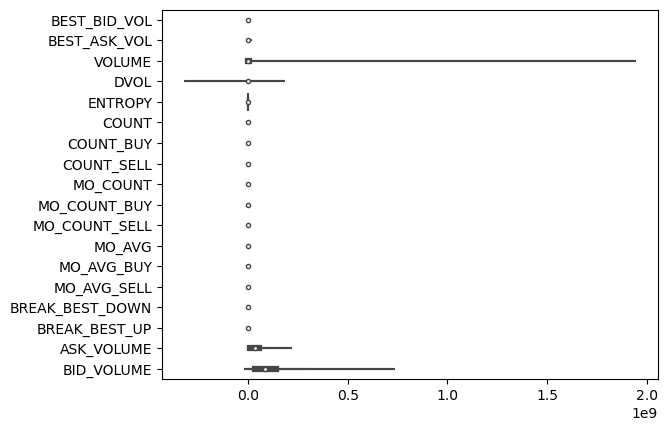

In [77]:
seaborn.violinplot(mdata_train, orient='h')

<Axes: >

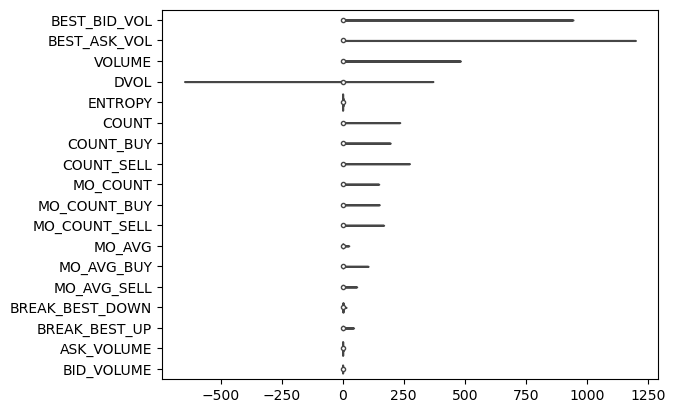

In [72]:
seaborn.violinplot(pd.DataFrame(mdata_train_robust, columns=mdata_train.columns),orient='h')

<Axes: >

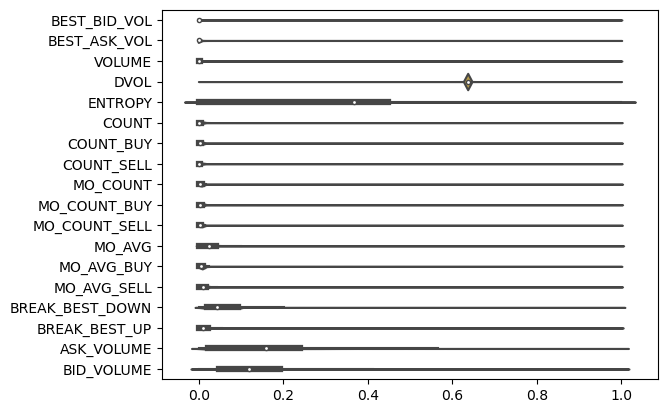

In [73]:
seaborn.violinplot(pd.DataFrame(mdata_train_minmax,columns=mdata_train.columns),orient='h')

<Axes: >

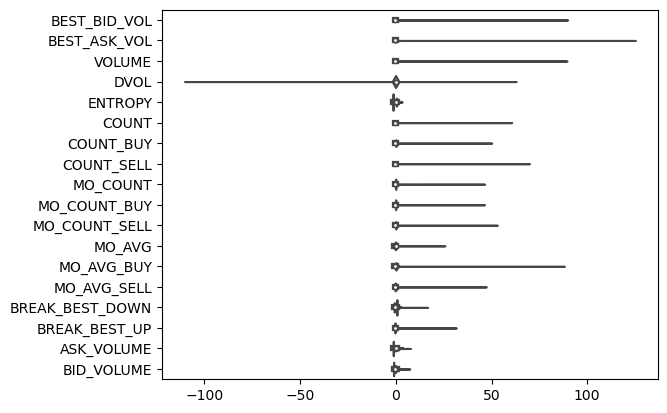

In [74]:
seaborn.violinplot(pd.DataFrame(mdata_train_standard,columns=mdata_train.columns),orient='h')

<Axes: >

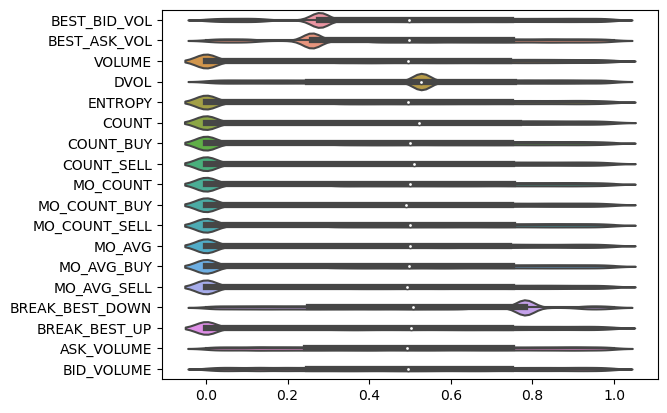

In [75]:
seaborn.violinplot(pd.DataFrame(mdata_train_quantile, columns=mdata_train.columns),orient='h')

AS EXPECTED THE BEST SMOOTHING IS OF QUANTILE TRANSFORMER SINCE IT
FITS (MAPS) THE SAMPLE TO THE NORMAL DISTRIBUTION
SO THE DIFFERENCE IS ONLY OF LOC, SCALE

### LINEAR MODEL FITTING

#### BASIC NO TRANSFORMATIONS

<Axes: >

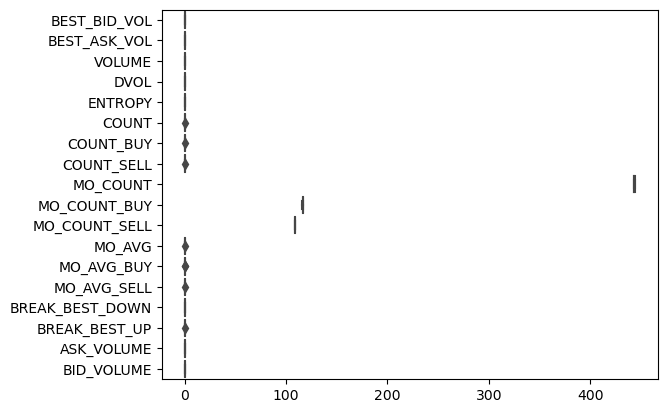

In [81]:
X = mdata_train
y = np.sign(returns_ahead_train.values)

lr = LinearRegression()
lr.fit(X, y)

result = permutation_importance(lr,X,y,n_repeats=10,random_state=23)
seaborn.boxplot(pd.DataFrame(result['importances'].T,columns=mdata_train.columns),orient='h')

#### ROBUST SCALER

<Axes: >

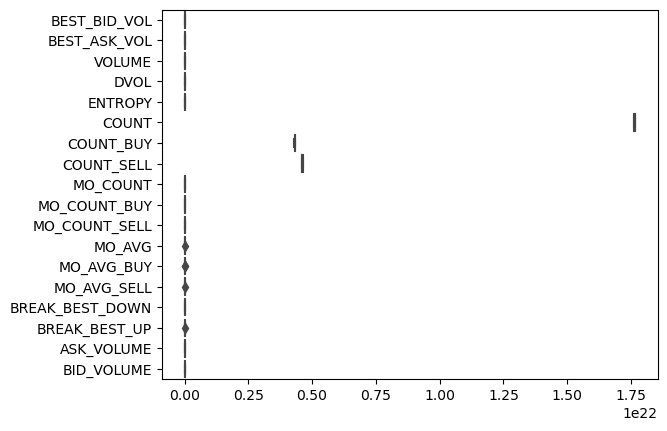

In [83]:
X = mdata_train_robust
y = np.sign(returns_ahead_train.values)

lr = LinearRegression()
lr.fit(X, y)

result = permutation_importance(lr,X,y,n_repeats=10,random_state=23)
seaborn.boxplot(pd.DataFrame(result['importances'].T,columns=mdata_train.columns),orient='h')

#### MINMAX SCALER

<Axes: >

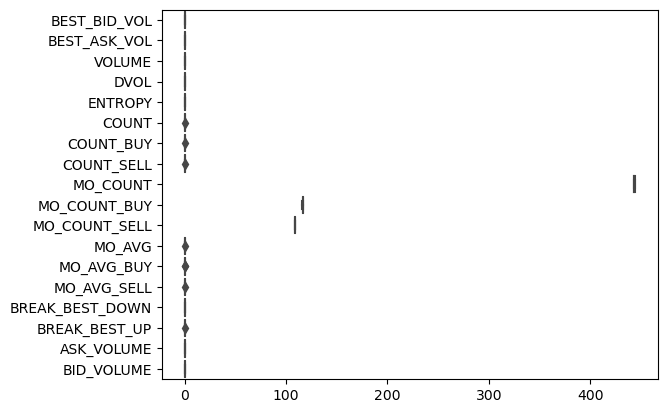

In [85]:
X = mdata_train_minmax
y = np.sign(returns_ahead_train.values)

lr = LinearRegression()
lr.fit(X, y)

result = permutation_importance(lr,X,y,n_repeats=10,random_state=23)
seaborn.boxplot(pd.DataFrame(result['importances'].T,columns=mdata_train.columns),orient='h')

#### STANDARD SCALER

<Axes: >

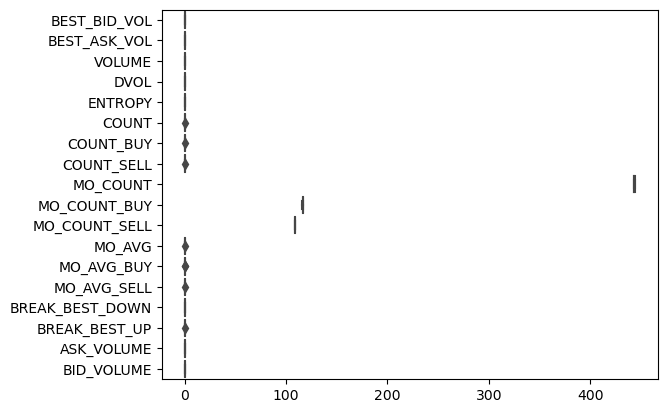

In [86]:
X = mdata_train_standard
y = np.sign(returns_ahead_train.values)

lr = LinearRegression()
lr.fit(X, y)

result = permutation_importance(lr,X,y,n_repeats=10,random_state=23)
seaborn.boxplot(pd.DataFrame(result['importances'].T,columns=mdata_train.columns),orient='h')

#### QUANTILE SCALER

<Axes: >

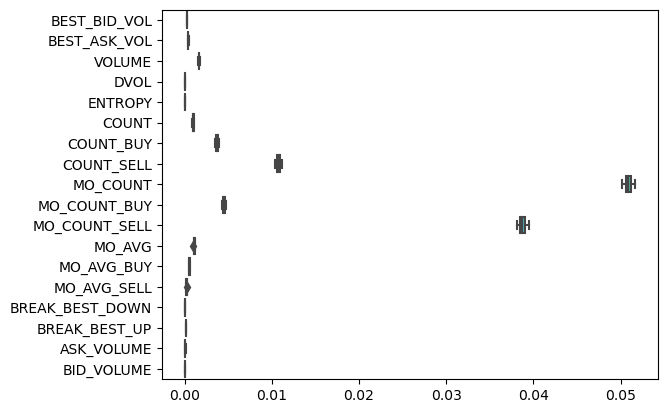

In [88]:
X = mdata_train_quantile
y = np.sign(returns_ahead_train.values)

lr = LinearRegression()
lr.fit(X, y)

result = permutation_importance(lr,X,y,n_repeats=10,random_state=23)
seaborn.boxplot(pd.DataFrame(result['importances'].T,columns=mdata_train.columns),orient='h')

#### NOTE

ONE CAN SEE THAT THE STRONGEST FEATURES (ACCORDING TO QUANTILE TRANSFORMER):
1. MO_COUNT
2. MO_COUNT_SELL
3. COUNT_SELL
4. MO_COUNT_BUY
5. COUNT_BUY

#### FIT LINEAR REGRESSION

In [91]:
best_features_mask = [
    'MO_COUNT', 'MO_COUNT_SELL', 'COUNT_SELL', 'MO_COUNT_BUY', 'COUNT_BUY'
]

In [117]:
quantile_scaler = QuantileTransformer().fit(mdata_train[best_features_mask])

X = quantile_scaler.transform(mdata_train[best_features_mask])
X_test = quantile_scaler.transform(mdata_test[best_features_mask])

y = np.sign(returns_ahead_train.values)
y_test = np.sign(returns_ahead_test.values)

lr = LinearRegression()
lr.fit(X, y)

regr_1  = lr.score(X_test, y_test)
regr_1t = lr.score(X, y)


quantile_scaler = QuantileTransformer().fit(mdata_train)

X = quantile_scaler.transform(mdata_train)
X_test = quantile_scaler.transform(mdata_test)

y = np.sign(returns_ahead_train.values)
y_test = np.sign(returns_ahead_test.values)

lr = LinearRegression()
lr.fit(X, y)

regr_2 = lr.score(X_test, y_test)
regr_2t = lr.score(X, y)

In [132]:
print(f'''
In sample performance:
R2 score for all features  = {regr_2t}
R2 score for the strongest = {regr_1t}
The model on selected features is worsier by {regr_2t - regr_1t:6f} or {(regr_2t - regr_1t)/regr_2t*100:.1f}%

Out of sample performance:
R2 score for all features  = {regr_2}
R2 score for the strongest = {regr_1}
The model on selected features is worsier by {regr_2 - regr_1:6f} or {(regr_2 - regr_1)/regr_2*100:.1f}%

The models performace drawdown:
All features  = {(-(regr_2 - regr_2t)/regr_2*100):.1f}%
The strongest = {(-(regr_1 - regr_1t)/regr_1*100):.1f}%

SO WE CAN SEE THAT USING ONLY THE MOST IMPORTANT FEATURES DEMONSTRATES 
(IN THIS PARTICULAR CASE!)
EVEN BETTER PERFORMANCE OUT OF SAMPLE THAN ON TRAIN SET UNLIKE THE MODEL WITH ALL FEATURES
THAT DEMONSTRATES DEGRADATION OF PERFORMANCE
AND WE CAN CONCLUDE THAT USING LESS BUT MORE IMPORTANT FEATURES LET US FIT 
MORE ROBUST AND STABLE MODEL FOR PREDICTIONS
''')


In sample performance:
R2 score for all features  = 0.0005414724924980296
R2 score for the strongest = 0.0002116327452614808
The model on selected features is worsier by 0.000330 or 60.9%

Out of sample performance:
R2 score for all features  = 0.00046645967872438465
R2 score for the strongest = 0.0003423934109137994
The model on selected features is worsier by 0.000124 or 26.6%

The models performace drawdown:
All features  = 16.1%
The strongest = -38.2%

SO WE CAN SEE THAT USING ONLY THE MOST IMPORTANT FEATURES DEMONSTRATES 
(IN THIS PARTICULAR CASE!)
EVEN BETTER PERFORMANCE OUT OF SAMPLE THAN ON TRAIN SET UNLIKE THE MODEL WITH ALL FEATURES
THAT DEMONSTRATES DEGRADATION OF PERFORMANCE
AND WE CAN CONCLUDE THAT USING LESS BUT MORE IMPORTANT FEATURES LET US FIT 
MORE ROBUST AND STABLE MODEL FOR PREDICTIONS

